**Loading packages and data**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input

# other imports
from sklearn.preprocessing import LabelEncoder
import numpy as np
import glob
import cv2
import h5py
import os
import datetime
import time
import re
from tqdm import tqdm


print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['labels.csv', 'train', 'test', 'sample_submission.csv']


**Read the training images**

In [2]:
# path to training dataset
train_path = '../input/train/'
labels = pd.read_csv('../input/labels.csv')

model_dir = '../input/'
list_images = [train_path+f for f in os.listdir(train_path) if re.search('jpg|JPG', f)]

print(list_images[0:4])
train_labels = os.listdir(train_path)


['../input/train/dab2023fc149d0c42f905ffaa78b2fa6.jpg', '../input/train/b2e1a5fd7eedab2fad957eed10d66733.jpg', '../input/train/bc7d13f323cfc48854ed90ca52078553.jpg', '../input/train/f644ec58aab5f57925bd55969f4b925b.jpg']


Train samples

In [3]:
labels.head(5)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
n = len(labels)
breed = set(labels['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
n_class = len(breed)


number of samples in the train data

In [5]:
print(n)

10222


How many labels do we have?

In [6]:
print(n_class)

120


There are 120 - breeds that are available in training set 

Breed count  per label

In [7]:

yy = pd.value_counts(labels['breed'])
print(yy[0:5])

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64


Distribution of breeds

Text(0.5, 1.0, 'Distribution of the Dog Breeds')

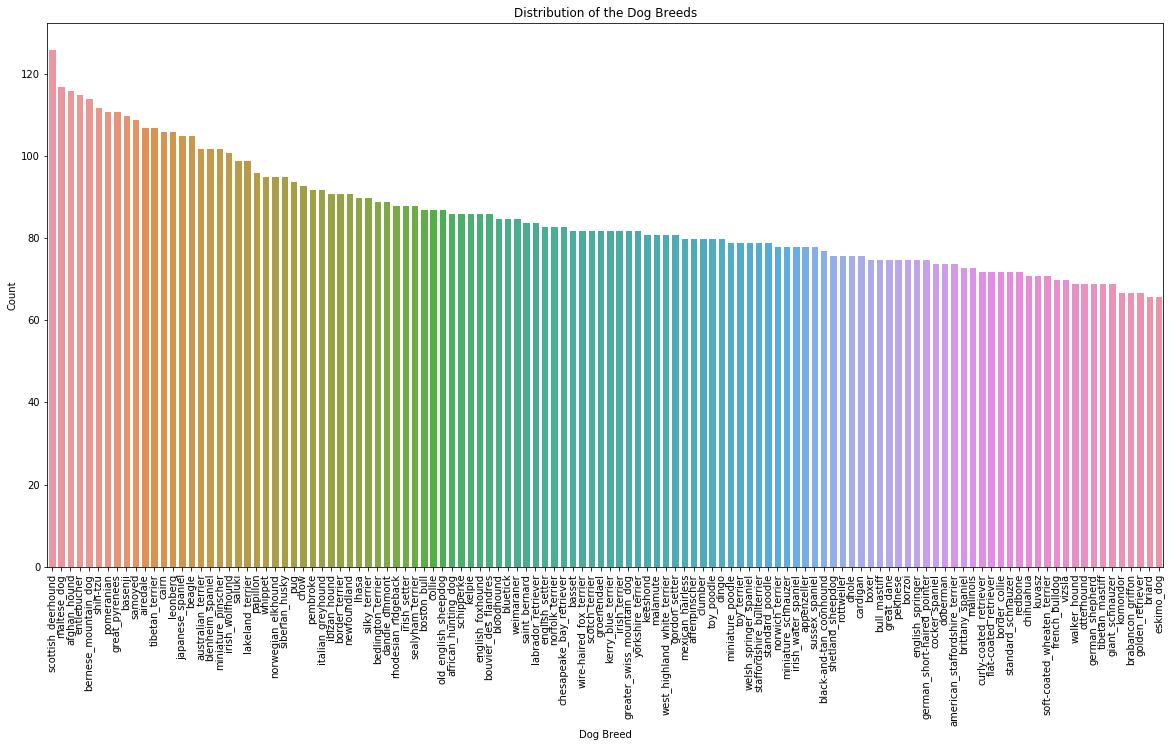

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of the Dog Breeds')

From the above barplot we see relevant size of sample data, each breed is having count between 65-126., which seems to be reasonable size.

Change the labels to one hot encodeded lables

In [9]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)


Resize the images

In [10]:
import cv2
width = 224
orig_label = []
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
orig_label = []
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('../input/train/%s.jpg' % labels['id'][i]), (width, width))
    y[i] = one_hot_labels[i]
    orig_label.append(labels['breed'][i])


100%|██████████| 10222/10222 [00:48<00:00, 208.83it/s]


In [11]:
print(orig_label[0:5])

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever']


How many samples and lables do we have

In [12]:
print("Number of Samples:",X.shape[0])
print(y.shape)
num_class = y.shape[1]
print("Number of training lables:",num_class)

Number of Samples: 10222
(10222, 120)
Number of training lables: 120


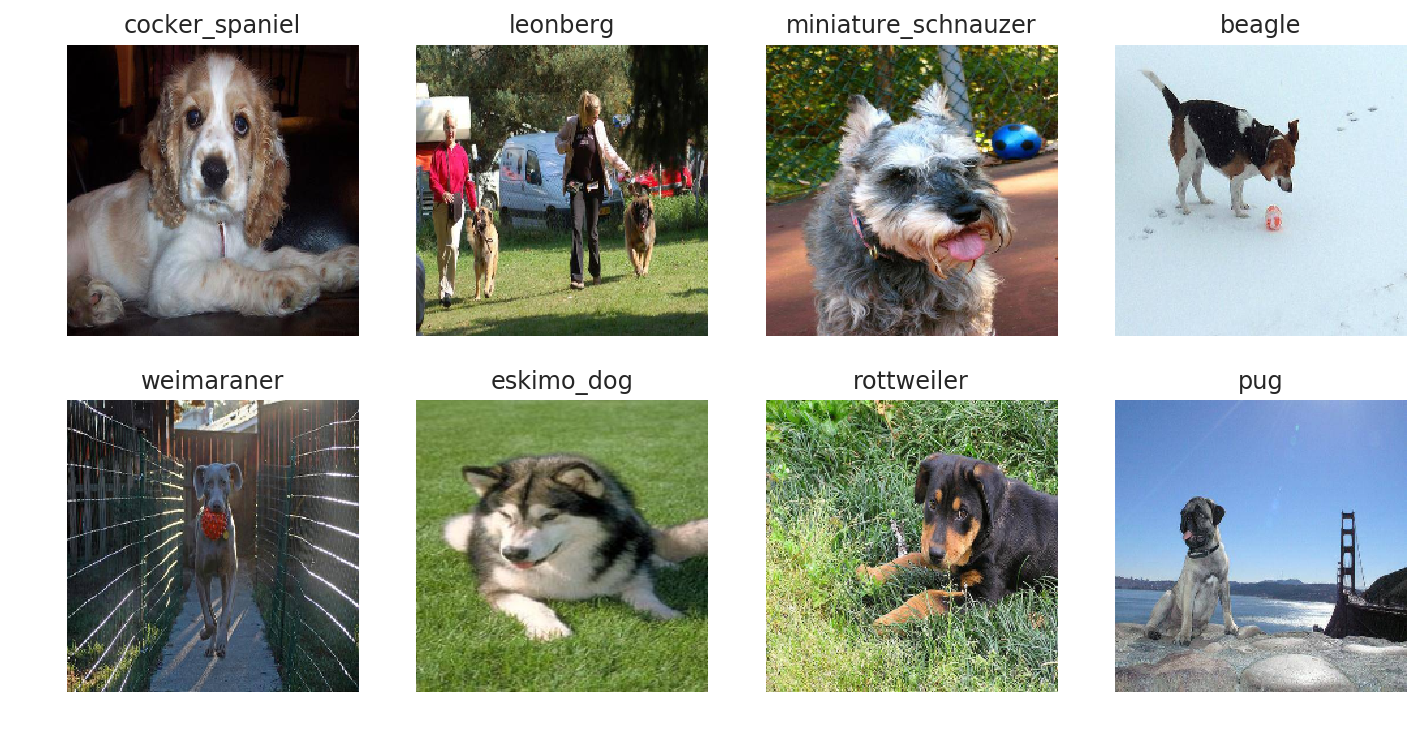

In [13]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(orig_label[random_index])
    plt.axis('off')

Normalize the train data

**Read the test data**

In [14]:
df_test = pd.read_csv('../input/sample_submission.csv')

**Load test images**

Resize the test images same as train

In [15]:
n_test = len(df_test)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('../input/test/%s.jpg' % df_test['id'][i]), (width, width))


100%|██████████| 10357/10357 [01:00<00:00, 172.44it/s]


In [16]:
print(len(X_test))

10357


**Feature Extraction using VGG**

In [17]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *

def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [18]:
vgg16_features = get_features(VGG16, X)

10222/10222 [==============================] - 31s 3ms/step


In [28]:
inputs = Input(vgg16_features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(vgg16_features, y, batch_size=40, epochs=100, validation_split=0.3)

Train on 7155 samples, validate on 3067 samples
Epoch 1/100
7155/7155 [==============================] - 1s 151us/step - loss: 14.4447 - acc: 0.0236 - val_loss: 11.7152 - val_acc: 0.0988
Epoch 2/100
7155/7155 [==============================] - 1s 87us/step - loss: 12.7119 - acc: 0.0790 - val_loss: 10.0468 - val_acc: 0.1953
Epoch 3/100
7155/7155 [==============================] - 1s 80us/step - loss: 10.9851 - acc: 0.1497 - val_loss: 8.5577 - val_acc: 0.2615
Epoch 4/100
7155/7155 [==============================] - 1s 80us/step - loss: 9.7610 - acc: 0.2046 - val_loss: 7.7116 - val_acc: 0.3111
Epoch 5/100
7155/7155 [==============================] - 1s 80us/step - loss: 8.7771 - acc: 0.2521 - val_loss: 7.0534 - val_acc: 0.3531
Epoch 6/100
7155/7155 [==============================] - 1s 82us/step - loss: 8.0288 - acc: 0.3015 - val_loss: 6.4830 - val_acc: 0.3802
Epoch 7/100
7155/7155 [==============================] - 1s 80us/step - loss: 7.4703 - acc: 0.3324 - val_loss: 5.9846 - val_acc: 0

7155/7155 [==============================] - 1s 80us/step - loss: 3.7607 - acc: 0.5726 - val_loss: 4.6068 - val_acc: 0.4888
Epoch 61/100
7155/7155 [==============================] - 1s 81us/step - loss: 3.7784 - acc: 0.5695 - val_loss: 4.6381 - val_acc: 0.4881
Epoch 62/100
7155/7155 [==============================] - 1s 81us/step - loss: 3.7568 - acc: 0.5776 - val_loss: 4.6988 - val_acc: 0.4832
Epoch 63/100
7155/7155 [==============================] - 1s 80us/step - loss: 3.7601 - acc: 0.5828 - val_loss: 4.8077 - val_acc: 0.4819
Epoch 64/100
7155/7155 [==============================] - 1s 80us/step - loss: 3.6996 - acc: 0.5754 - val_loss: 4.7098 - val_acc: 0.4845
Epoch 65/100
7155/7155 [==============================] - 1s 79us/step - loss: 3.7864 - acc: 0.5782 - val_loss: 4.6626 - val_acc: 0.4839
Epoch 66/100
7155/7155 [==============================] - 1s 81us/step - loss: 3.7530 - acc: 0.5747 - val_loss: 4.6606 - val_acc: 0.4936
Epoch 67/100
7155/7155 [==============================

In [29]:
vgg16_feature_test = get_features(VGG16, X_test)

10357/10357 [==============================] - 27s 3ms/step


In [30]:
y_pred = model.predict(vgg16_feature_test, batch_size=128)

In [31]:
for b in breed:
    df_test[b] = y_pred[:,class_to_num[b]]

In [32]:
 
df_test.to_csv('submission.csv', index=None)